# Linear regression assignment (Bike sharing case study)

## 0. Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## 1. Loading and understanding the data

The given dataset has `730 rows` and `16 columns`.

In [2]:
# data-loading

data = pd.read_csv('day.csv')
data.shape

(730, 16)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


## 2. Dataset validations

### 2.1 Validate for null or empty columns

The given dataset does not contain any null or empty columns.

In [4]:
# check for null or empty columns

data.isnull().mean()*100

instant       0.0
dteday        0.0
season        0.0
yr            0.0
mnth          0.0
holiday       0.0
weekday       0.0
workingday    0.0
weathersit    0.0
temp          0.0
atemp         0.0
hum           0.0
windspeed     0.0
casual        0.0
registered    0.0
cnt           0.0
dtype: float64

### 2.2 Check header and footer

The given dataset does not contain any extra header or footer row.

In [5]:
# check header

data.head(2)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801


In [6]:
# check footer

data.tail(2)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
728,729,30-12-2019,1,1,12,0,0,0,1,10.489153,11.58500,48.3333,23.500518,364,1432,1796
729,730,31-12-2019,1,1,12,0,1,1,2,8.849153,11.17435,57.7500,10.374682,439,2290,2729


### 2.3 Check for duplicate rows

The given dataset does not contain any duplicate rows.

In [7]:
# check duplicate rows

data[data.duplicated()]

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt


### 2.4 Data check
 
- The given dataset has valida data on `cnt` column as every row satisfies `data['casual'] + data['registered'] = data['cnt']`
- Each numeric column i.e. `temp`, `atemp`, `hum` and `windspeed` has positive value.

In [8]:
# data check

data[data['casual'] + data['registered'] != data['cnt']]

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt


In [9]:
# data check

data[(data['temp'] < 0) | (data['atemp'] < 0) | (data['hum'] < 0) | (data['windspeed'] < 0)]

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt


## 3. Basic EDA on data

### 3.1 Data cleaning - remove unnecessary columns

In given dataset there are some columns which do not play an important role in prediction, so we will remove them. These columns are `instant`, `dteday`, `registered` and `casual`.

In [10]:
# data cleaning - remove unnecessary columns

data = data.drop(columns=['instant', 'dteday', 'registered', 'casual'], axis = 1)

### 3.2 Variables identification

Based on characteristics of columns we can classified into various categories
- *categorical variables:* `season`, `yr`, `mnth`, `holiday`, `weekday`, `workingday`, `weathersit`
- *numeric variables:* `temp`, `atemp`, `hum`, `windspeed`
- *target variable:* `cnt`

In [11]:
# variables identification

target_var = 'cnt'
categorical_vars = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
numeric_vars = ['cnt', 'temp', 'atemp', 'hum', 'windspeed']

### 3.3 Change data type of categorical variables

In the given dataset the data type of categorical variables is `int` which should be `object`.

In [12]:
# change dtype of columns having categorical data

data[categorical_vars] = data[categorical_vars].apply(lambda x: x.astype('object'))

### 3.4 Relationship between target variable and numeric variables

- `temp` and `atemp` follow a linear trend with `cnt`
- `hum` and `windspeed` do not follow any trend with `cnt`

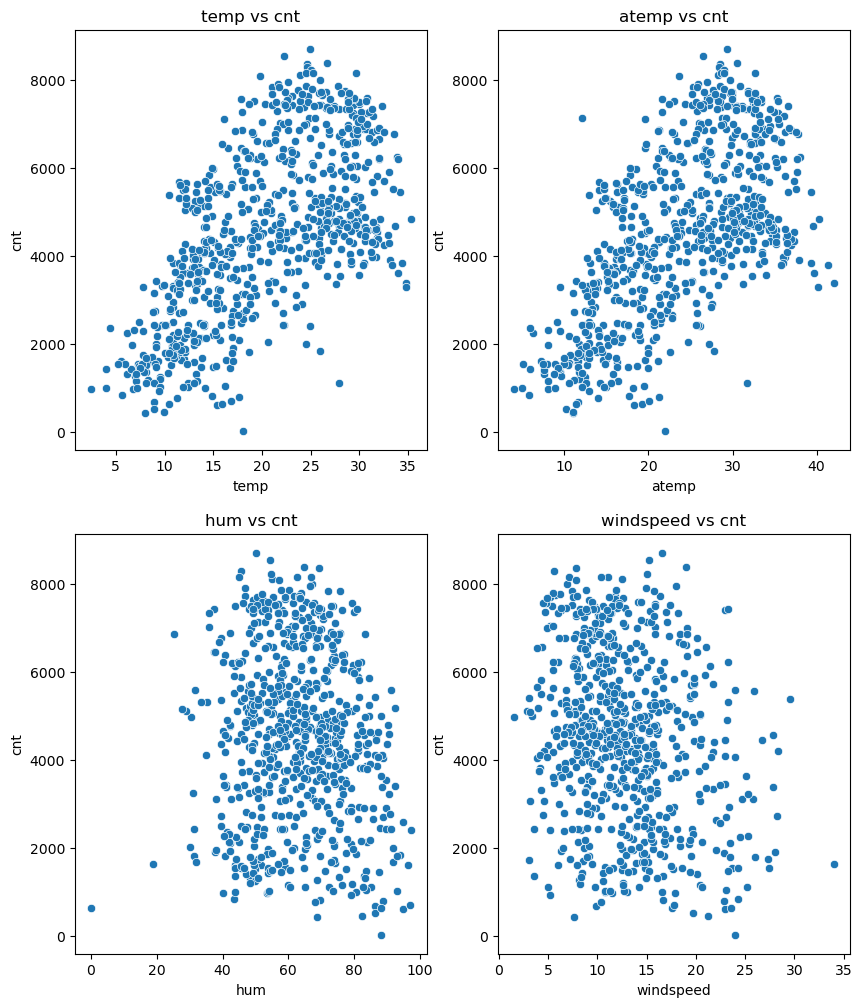

In [13]:
# scatter plot among numeric variables and target variable

plt.figure(figsize=(10, 12))

for i in range(1, len(numeric_vars)):
    plt.subplot(2, 2, i)
    plt.title('{} vs {}'.format(numeric_vars[i], target_var))
    sns.scatterplot(x = data[numeric_vars[i]], y = data[target_var])

plt.show()

### 3.5 Relationship between target variable and categorical variables

- `cnt` is increasing over the `season` and season 3 (fall) has highest cnt value.
- Year 2019 has more `cnt` than 2018
- `cnt` is first increasing and then decreasing over the `mnth` and month June, July and August have highest cnt value.
- No holiday has more `cnt` than holiday.
- `weekday` and `workingday` do not vary with `cnt`
- `cnt` is decreasing over the `weathersit`and weather situation 1 (Clear, Few clouds, Partly cloudy, Partly cloudy) has highest cnt value.

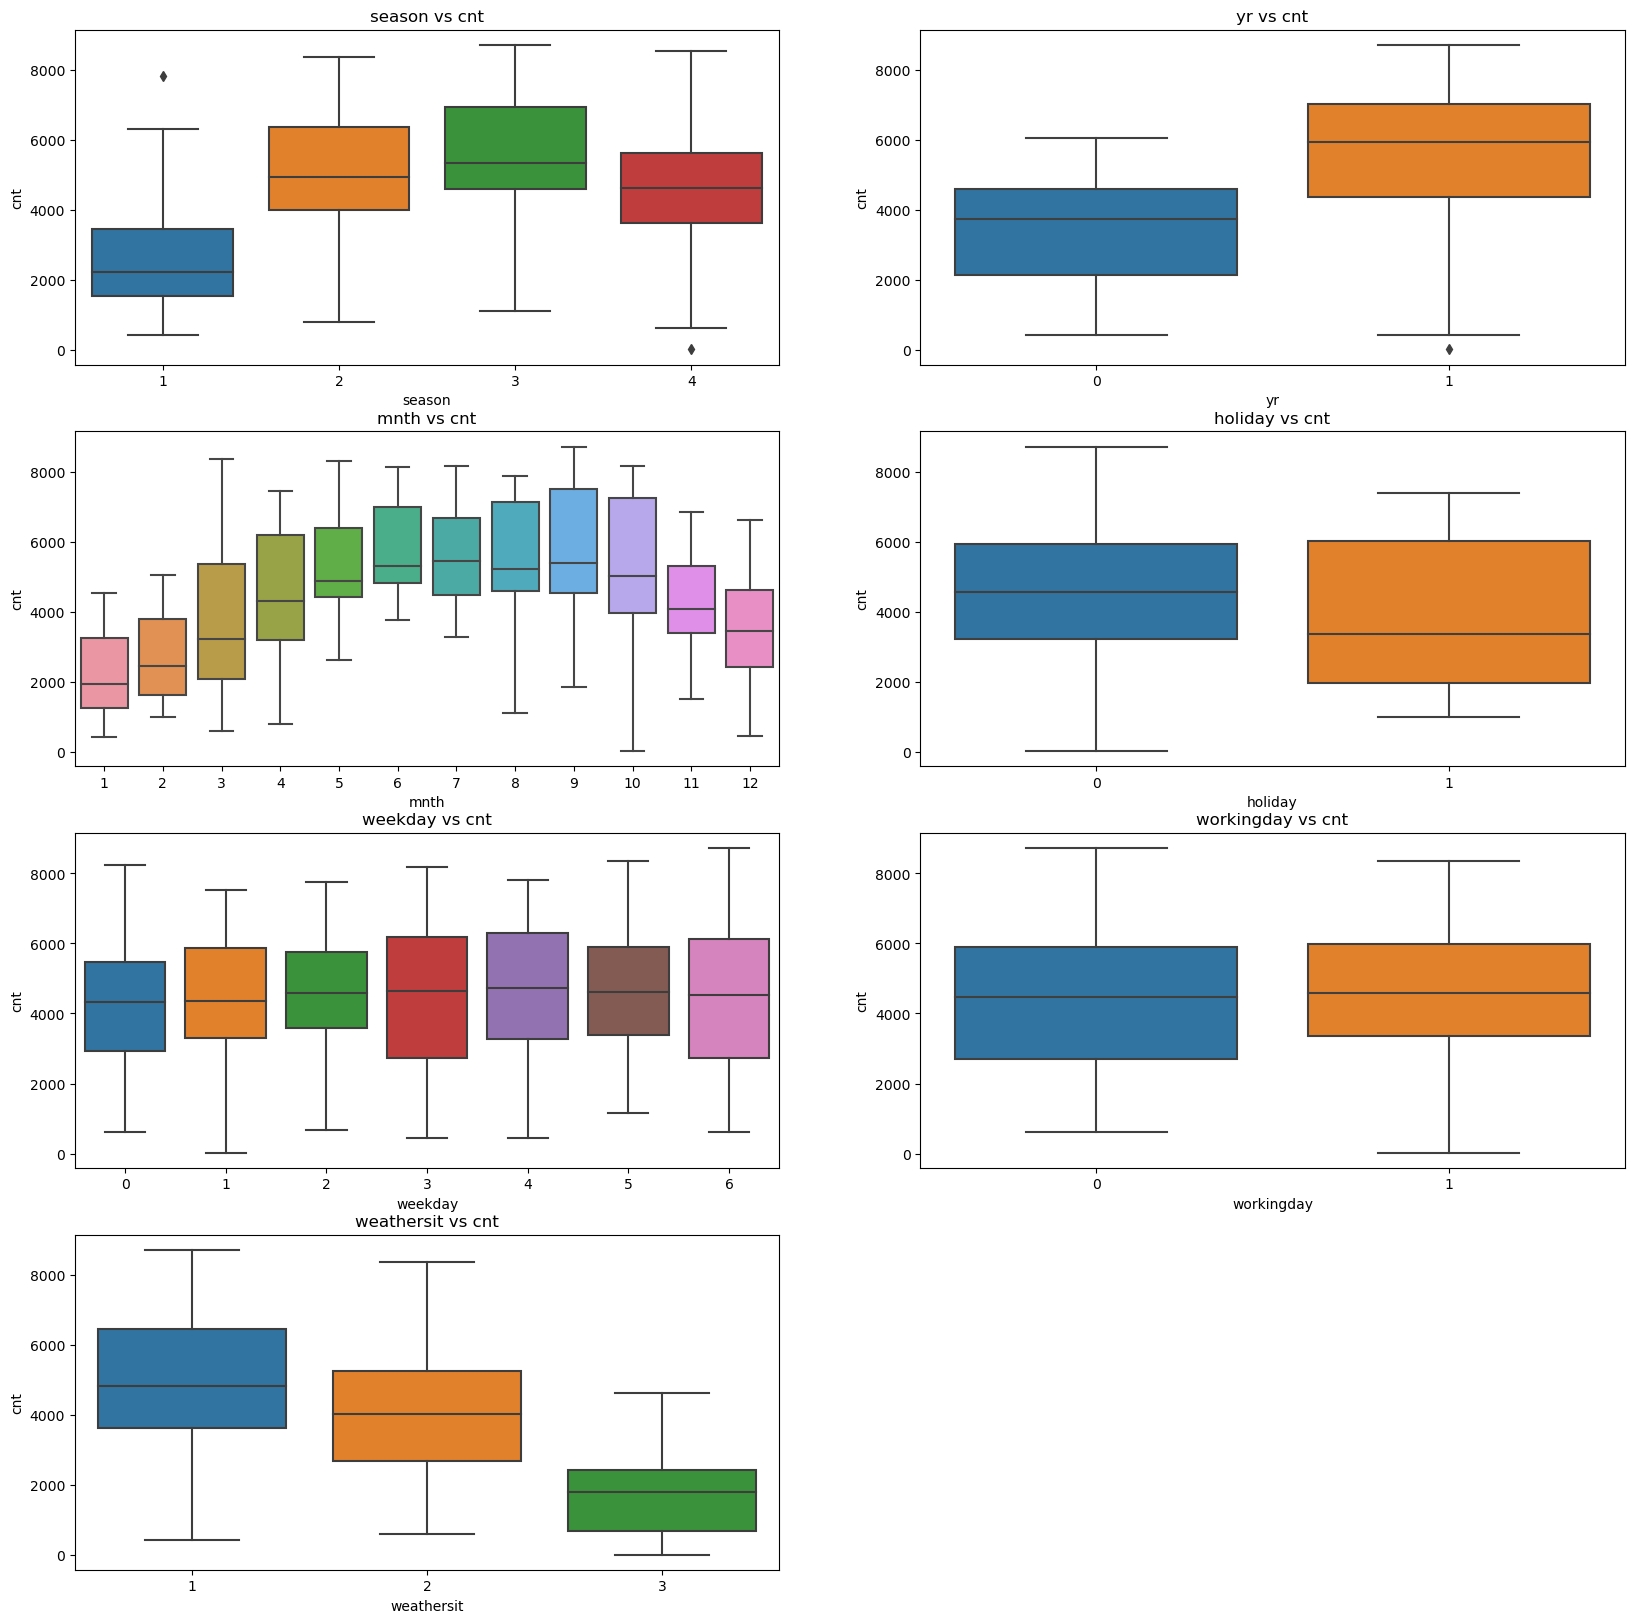

In [14]:
# box plot among categorical variables and target variable

plt.figure(figsize=(20, 20))

for i in range(0, len(categorical_vars)):
    plt.subplot(4, 2, i+1)
    plt.title('{} vs {}'.format(categorical_vars[i], target_var))
    sns.boxplot(x = data[categorical_vars[i]], y = data[target_var])

plt.show()

With above EDA we can conclude that linear regression can be apply in this dataset, since our dependent variable(target variable) is a continous variable and all other independent variables mostly follow a linear trend with the target variable.

## 4. Data preparation

### 4.1 Handling of categorical variables

- To handle categorical variables, we create dummy variables denoting all the levels of categorical variable.
- No need to create dummy variables for binary categorical variables.
- Change datatype to `int`

In [15]:
# handle categorical variables

data = pd.get_dummies(data, columns=['season', 'mnth', 'weekday', 'weathersit'], drop_first=True, dtype='int32')
data[['yr', 'holiday', 'workingday']] = data[['yr', 'holiday', 'workingday']].apply(lambda x: x.astype('int32'))

### 4.2 Split train and test data

- Split by using 70-30 rule
- Train data has 510 rows and 30 columns
- Test data has 220 rows and 30 columns

In [16]:
# split train and test data with 70-30 rule

train_data, test_data = train_test_split(data, train_size=0.7, random_state=100)

print(train_data.shape)
print(test_data.shape)

(510, 30)
(220, 30)


### 4.3 Rescaling of numeric variables

- Since values of numeric variables are much higher that categorical one, so we have to rescale them.
- Rescale the variables by using `min-max scaling`
- After rescaling all the variables value lies in the range `[0, 1]`

In [17]:
# rescaling on train data

scalar = MinMaxScaler()
scalar.fit(train_data[numeric_vars])
train_data[numeric_vars] = scalar.transform(train_data[numeric_vars])
train_data.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_2,season_3,...,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.537440,0.513156,0.650480,0.320883,0.513499,0.247059,0.262745,...,0.086275,0.084314,0.150980,0.131373,0.158824,0.133333,0.127451,0.154902,0.345098,0.029412
std,0.500429,0.157763,0.468282,0.225858,0.212410,0.145846,0.169803,0.224421,0.431725,0.440557,...,0.281045,0.278131,0.358381,0.338139,0.365870,0.340268,0.333805,0.362166,0.475867,0.169124
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.542596,0.529718,0.653714,0.296763,0.518638,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 4.4 Compute X_train and y_train

In [18]:
# compute X_train and y_train

X_train = train_data.drop(columns=['cnt'], axis = 1)
y_train = train_data['cnt']

## 5. Linear regression model building

### 5.1 Define utility functions

- We define 2 functions to reuse the same code in our linear regression model building approach.
- Function `compute_vif(X)` will return the `vif` dataframe, which will be use to detect multicollinearity in the model.
- Function `build_model(X, y, num_of_features=None)` will construct our linear regression model.
- To construct the model we need feature selection and for this we are using `RFE` approach.

In [19]:
# function definition for vif computation

def compute_vif(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(0, X.shape[1])]
    vif = vif.sort_values(by = 'VIF', ascending=False)
    
    return vif

In [20]:
# function definition to construct model

def build_model(X, y, num_of_features=None):
    if num_of_features != None:
        # consturct linear model for feature selection
        lr = LinearRegression()
        lr.fit(X, y)

        # top n feature selection with RFE
        rfe = RFE(lr, n_features_to_select=num_of_features)
        rfe.fit(X, y)

        # remove unnecessary features
        print(X.columns[rfe.support_])
        X = X.drop(columns = X.columns[~rfe.support_])
    
    # build model
    X_sm = sm.add_constant(X)
    model = sm.OLS(y, X_sm).fit()
    
    # compute vif
    vif_vals = compute_vif(X)
    
    return model, vif_vals

### 5.2 Check pair wise correlations

- Below heat map clearly shows that the most of the independent variables are highly multicollinear with the dependent variable.
- So we can not start to build our model with all the independent variables.

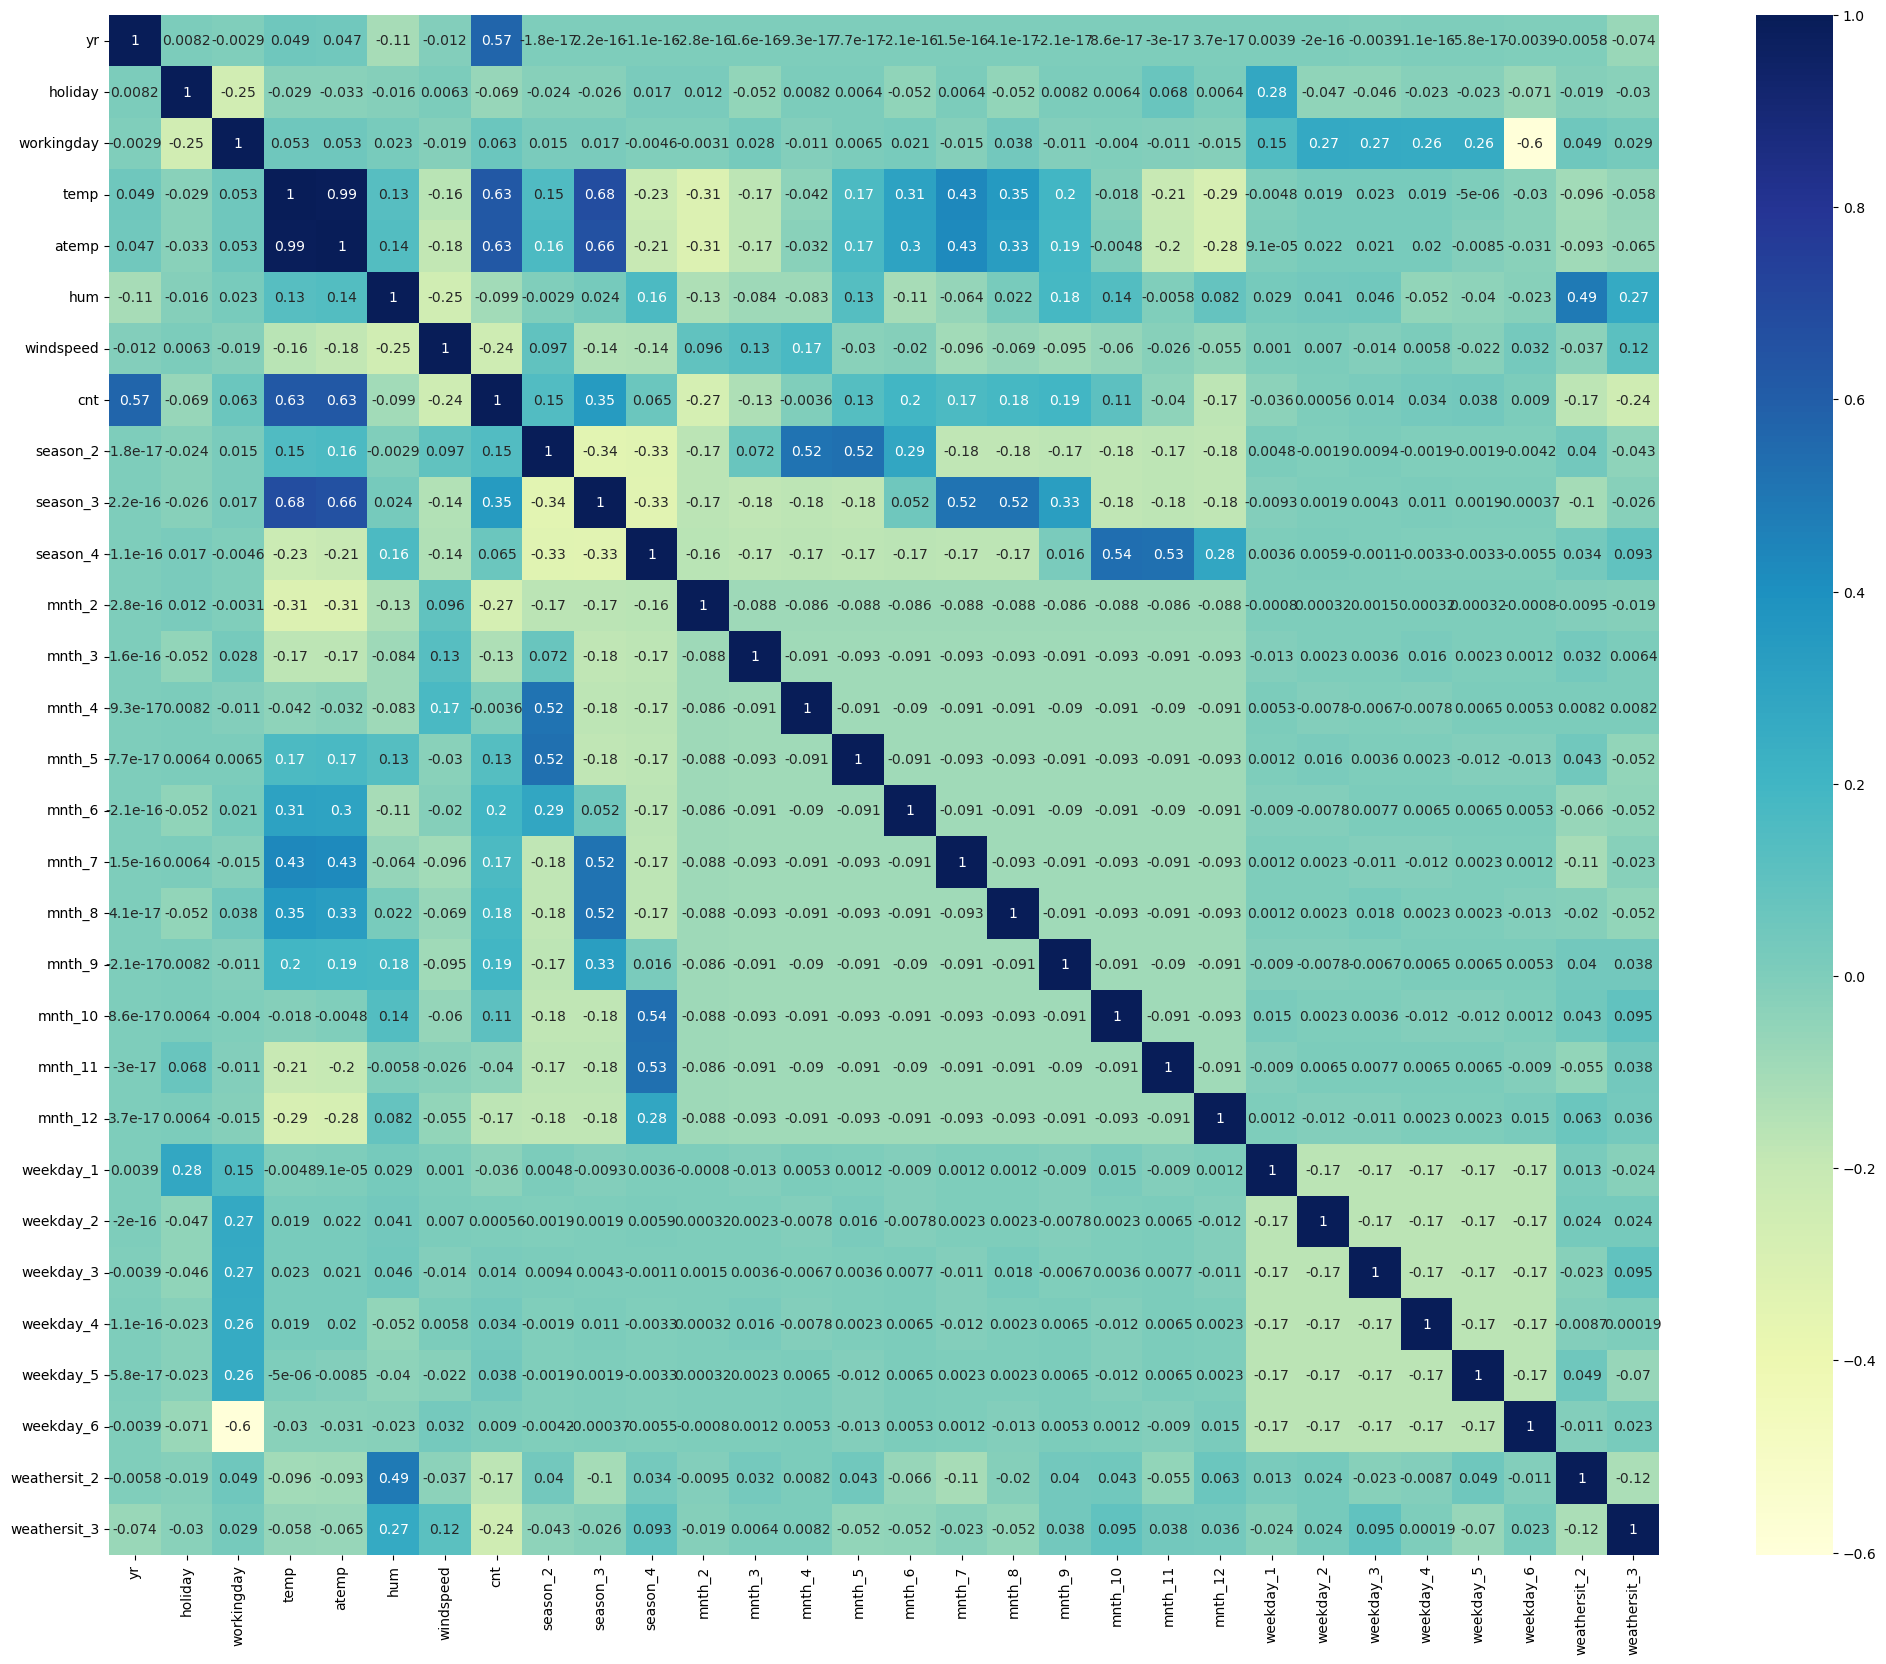

In [21]:
#  check pair wise correlations in data for multicollinearity detection

plt.figure(figsize = (25,20))
sns.heatmap(data.corr(), annot=True, cmap='YlGnBu')
plt.show()

### 5.3 MODEL-1, Select top 25 features using RFE

- There are 29 independent variables and we are starting to build our model with top 25 features.
- After building the model we observe that there are many features are present with high p-values(> 0.05).
- The VIF values are also high in this model, which shows that the dependent variables are highly multicollinear with the dependent variable.
- This analysis conclude that this model is not a correct model for prediction.

In [22]:
lr_model, lr_vif_vals = build_model(X_train, y_train, num_of_features=25)
print(lr_model.summary())
print(lr_vif_vals)

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'season_2', 'season_3', 'season_4', 'mnth_2', 'mnth_3', 'mnth_4',
       'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11',
       'mnth_12', 'weekday_1', 'weekday_6', 'weathersit_2', 'weathersit_3'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     111.6
Date:                Mon, 01 Apr 2024   Prob (F-statistic):          5.16e-183
Time:                        10:37:14   Log-Likelihood:                 526.33
No. Observations:                 510   AIC:                            -1001.
Df Residuals:                     484   BIC:                            -890.6
Df Model:                          25     

### 5.4 MODEL-2, Select top 20 features using RFE

- Since above model with 25 features is incorrect, so will drop some features this time and let's start to build our model with top 20 features.
- After building the model we observe that there are many features are present with high p-values(> 0.05).
- The VIF values are also high in this model, which shows that the dependent variables are highly multicollinear with the dependent variable.
- This analysis conclude that this model is not a correct model for prediction.

In [23]:
lr_model, lr_vif_vals = build_model(X_train, y_train, num_of_features=20)
print(lr_model.summary())
print(lr_vif_vals)

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'season_2', 'season_3', 'season_4', 'mnth_3', 'mnth_4', 'mnth_5',
       'mnth_6', 'mnth_8', 'mnth_9', 'mnth_10', 'weekday_6', 'weathersit_2',
       'weathersit_3'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     139.7
Date:                Mon, 01 Apr 2024   Prob (F-statistic):          1.53e-187
Time:                        10:37:14   Log-Likelihood:                 524.48
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     489   BIC:                            -918.0
Df Model:                          20                                         
Covariance Type:  

### 5.5 MODEL-3, Select top 15 features using RFE

- Since above model with 20 features is incorrect, so will drop some features this time and let's start to build our model with top 15 features.
- After building the model we observe that there are many features are present with high p-values(> 0.05).
- The VIF values are also high in this model, which shows that the dependent variables are highly multicollinear with the dependent variable.
- Although this model is significantly better than above 2 models but the analysis conclude that this model is also not a correct model for prediction.

In [24]:
lr_model, lr_vif_vals = build_model(X_train, y_train, num_of_features=15)
print(lr_model.summary())
print(lr_vif_vals)

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'season_2',
       'season_3', 'season_4', 'mnth_8', 'mnth_9', 'mnth_10', 'weekday_6',
       'weathersit_2', 'weathersit_3'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     183.9
Date:                Mon, 01 Apr 2024   Prob (F-statistic):          5.17e-191
Time:                        10:37:14   Log-Likelihood:                 519.44
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     494   BIC:                            -939.1
Df Model:                          15                                         
Covariance Type:            nonrobust                                     

### 5.6 MODEL-4, Removing `season_3` feature

- In above model-3, the feature `season_3` has highest p-value(0.184), so in this model we will remove them.
- After building the model we observe that all the features has lesser p-values(<= 0.05).
- The VIF values are high(> 5) in this model for features `hum` and `temp`, which shows that these variables are highly multicollinear with the dependent variable.
- Although this model is significantly better than above 3 models but due to presence of multicollinearity this model is also not a correct model for prediction.

In [25]:
X_train = X_train[lr_vif_vals['Features'].values] #reconstruct X_train from model-3 features
X_train = X_train.drop(columns=['season_3'])

lr_model, lr_vif_vals = build_model(X_train, y_train)
print(lr_model.summary())
print(lr_vif_vals) 

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     196.6
Date:                Mon, 01 Apr 2024   Prob (F-statistic):          8.70e-192
Time:                        10:37:15   Log-Likelihood:                 518.52
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     495   BIC:                            -943.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1948      0.029      6.769   

### 5.7 MODEL-5, Removing `hum` feature

- In above model-4, the feature `hum` has highest VIF(16.57), so in this model we will remove it.
- After building the model we observe that only `mnth_10` feature has high p-value(> 0.05).
- The VIF values are high(> 5) in this model for feature and `temp`, which shows that this variable is highly multicollinear with the dependent variable.
- Although this model is significantly better than above 4 models but due to presence of multicollinearity and high p-value this model is also not a correct model for prediction.

In [26]:
X_train = X_train.drop(columns=['hum'])

lr_model, lr_vif_vals = build_model(X_train, y_train)
print(lr_model.summary())
print(lr_vif_vals)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     201.8
Date:                Mon, 01 Apr 2024   Prob (F-statistic):          1.97e-188
Time:                        10:37:15   Log-Likelihood:                 507.76
No. Observations:                 510   AIC:                            -987.5
Df Residuals:                     496   BIC:                            -928.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0937      0.019      4.914   

### 5.8 MODEL-6, Removing `mnth_10` feature

- In above model-5, the feature `mnth_10` has highest p-value(0.052), so in this model we will remove it.
- After building the model we observe that all the features has lesser p-values(<= 0.05).
- The VIF values are high(> 5) in this model for feature and `temp`, which shows that this variable is highly multicollinear with the dependent variable.
- Although this model is significantly better than above 5 models but due to presence of multicollinearity this model is also not a correct model for prediction.

In [27]:
X_train = X_train.drop(columns=['mnth_10'])

lr_model, lr_vif_vals = build_model(X_train, y_train)
print(lr_model.summary())
print(lr_vif_vals)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     217.0
Date:                Mon, 01 Apr 2024   Prob (F-statistic):          8.64e-189
Time:                        10:37:15   Log-Likelihood:                 505.81
No. Observations:                 510   AIC:                            -985.6
Df Residuals:                     497   BIC:                            -930.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0903      0.019      4.740   

### 5.9 MODEL-7, Removing `holiday` feature

- In above model-6, although all the features have lesser p-values(<=0.05) but among all of them the feature `holiday` has highest p-value(0.042), so in this model we will remove it.
- After building the model we observe that all the features has lesser p-values(<= 0.05).
- The VIF values are high(> 5) in this model for feature and `temp`, which shows that this variable is highly multicollinear with the dependent variable.
- Although this model is significantly better than above 6 models but due to presence of multicollinearity this model is also not a correct model for prediction.

In [28]:
X_train = X_train.drop(columns=['holiday'])

lr_model, lr_vif_vals = build_model(X_train, y_train)
print(lr_model.summary())
print(lr_vif_vals)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     234.9
Date:                Mon, 01 Apr 2024   Prob (F-statistic):          4.31e-189
Time:                        10:37:15   Log-Likelihood:                 503.70
No. Observations:                 510   AIC:                            -983.4
Df Residuals:                     498   BIC:                            -932.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0809      0.019      4.365   

### 5.10 MODEL-8, Removing `mnth_8` feature

- In above model-6, although all the features have lesser p-values(<=0.05) but among all of them the feature `mnth_8` has highest p-value(0.002), so in this model we will remove it.
- After building the model we observe that all the features has lesser p-values(<= 0.05).
- All the VIF values are lesser than 5, so we can conclude that there is no multicollinearity between independent variables and the target variable.
- **Since this model is non-multicollinear and has p-values = 0 for all the features, we can say that this is our final model for the prediction.**

In [29]:
X_train = X_train.drop(columns=['mnth_8'])

lr_model, lr_vif_vals = build_model(X_train, y_train)
print(lr_model.summary())
print(lr_vif_vals)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     253.0
Date:                Mon, 01 Apr 2024   Prob (F-statistic):          3.13e-188
Time:                        10:37:15   Log-Likelihood:                 498.79
No. Observations:                 510   AIC:                            -975.6
Df Residuals:                     499   BIC:                            -929.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0750      0.019      4.031   

## 6. Residual analysis on trained model

In [30]:
# p-values of model

round(lr_model.pvalues, 3)

const           0.0
temp            0.0
workingday      0.0
windspeed       0.0
season_2        0.0
season_4        0.0
weathersit_2    0.0
yr              0.0
weekday_6       0.0
mnth_9          0.0
weathersit_3    0.0
dtype: float64

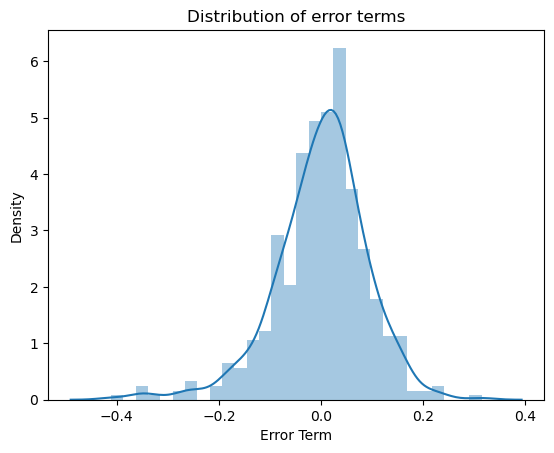

In [31]:
# computation of error terms

X_train_sm = sm.add_constant(X_train)
y_train_pred = lr_model.predict(X_train_sm)
err_terms_pred = y_train - y_train_pred

sns.distplot(err_terms_pred)
plt.xlabel('Error Term')
plt.title('Distribution of error terms')
plt.show()

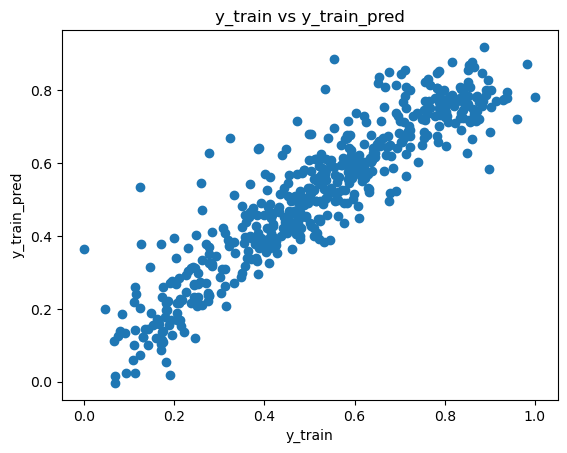

In [32]:
# scatter plot between y_train and y_train_pred

plt.scatter(x = y_train, y = y_train_pred)
plt.xlabel('y_train')
plt.ylabel('y_train_pred')
plt.title('y_train vs y_train_pred')
plt.show()

## 7. Data preparation on testing dataset

In [33]:
# rescaling on test data

test_data[numeric_vars] = scalar.transform(test_data[numeric_vars])
test_data.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_2,season_3,...,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
184,0,1,0,0.831783,0.769660,0.657364,0.084219,0.692706,0,1,...,0,0,1,0,0,0,0,0,1,0
535,1,0,1,0.901354,0.842587,0.610133,0.153728,0.712034,1,0,...,0,0,0,0,1,0,0,0,0,0
299,0,0,1,0.511964,0.496145,0.837699,0.334206,0.303382,0,0,...,0,0,0,0,0,1,0,0,1,0
221,0,0,1,0.881625,0.795343,0.437098,0.339570,0.547400,0,1,...,0,0,0,0,1,0,0,0,0,0
152,0,0,1,0.817246,0.741471,0.314298,0.537414,0.569029,1,0,...,0,0,0,0,0,1,0,0,0,0


In [34]:
# create X_test and y_test

X_test = test_data[X_train.columns]
y_test = test_data['cnt']

## 8. Predections on test data

In [35]:
# compute y_test_pred

X_test_sm = sm.add_constant(X_test)
y_test_pred = lr_model.predict(X_test_sm)

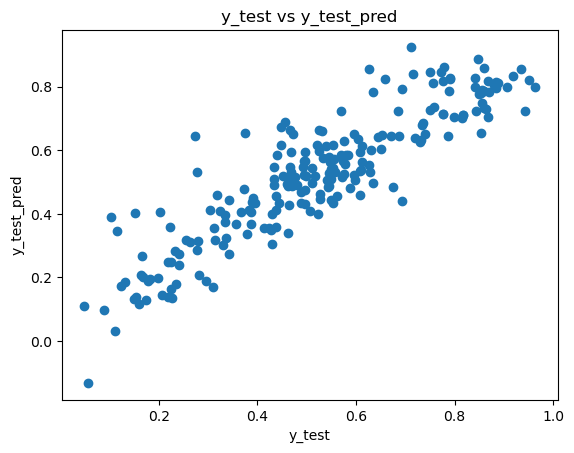

In [36]:
# scatter plot between y_test and y_test_pred

plt.scatter(x = y_test, y = y_test_pred)
plt.xlabel('y_test')
plt.ylabel('y_test_pred')
plt.title('y_test vs y_test_pred')
plt.show()

## 9. Model evaluation

In [37]:
# compute r-squared value for train data

r2_train = round(lr_model.rsquared, 3)

In [38]:
# compute r-squared value for test data

r2_test = round(r2_score(y_true=y_test, y_pred=y_test_pred), 3)

In [39]:
# compute adjusted r-squared value for train data

adj_r2_train = round(lr_model.rsquared_adj, 3)

In [40]:
# compute adjusted r-squared value for test data

N = X_test.shape[0]
p = X_test.shape[1]
r2 = r2_test

adj_r2_test = round(1 - (1-r2)*(N-1) / (N-p-1), 3)

In [41]:
# print values

print('R-squared for trained data = {}'.format(r2_train))
print('Adjusted R-squared for trained data = {}'.format(adj_r2_train))

print('R-squared for test data = {}'.format(r2_test))
print('Adjusted R-squared for test data = {}'.format(adj_r2_test))

R-squared for trained data = 0.835
Adjusted R-squared for trained data = 0.832
R-squared for test data = 0.796
Adjusted R-squared for test data = 0.786


## 10. Conclusions

In [42]:
# parameters 

lr_model.params

const           0.075009
temp            0.549892
workingday      0.056117
windspeed      -0.155203
season_2        0.088621
season_4        0.130655
weathersit_2   -0.080022
yr              0.233139
weekday_6       0.067500
mnth_9          0.097365
weathersit_3   -0.287090
dtype: float64

In [43]:
# difference between train and test accuracy

round((adj_r2_train - adj_r2_test) * 100, 3)

4.6

In [44]:
# difference between train and test accuracy

round((r2_train - r2_test) * 100, 3)

3.9